In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import statsmodels
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import math 

In [33]:
def EDA_df(path_label, path_weather):
  
  """
  Takes energy_dataset and weather_dataset as input and returns preprocessed
  dataframe with features, and label.

  Label is "total load actual".(We proposed wind generation but it is hard to predict.)
  Weather features consist of 5 different locations' 4 year weather features. 
  We summed the weather features since the energy dataset contains total
  generation for Spain.
  Some string features of weather description are ommitted. weather_main column
  is encoded with predetermined dictionary.
  Finally, energy fetaures are also concatenated as features.
  """
  labels_df = pd.read_csv(path_label, parse_dates = True, index_col= 0)
  weather_Df = pd.read_csv(path_weather, parse_dates = True, index_col= 0)
  labels_df.index = pd.to_datetime(labels_df.index, utc=True)
  weather_Df.index = pd.to_datetime(weather_Df.index, utc = True)

  labels_df.index= labels_df.index.tz_convert(1*60*60).tz_localize(None)
  weather_Df.index = weather_Df.index.tz_convert(1*60*60).tz_localize(None)
  labels_df = labels_df[~labels_df.index.duplicated()]
  labels_df = labels_df.asfreq("1H")
  labels_df = labels_df.fillna(0)
  label = labels_df["total load actual"]
  other_generation = labels_df[["generation solar"]]
  weather_main_map = {"clear":0,"clouds":1,"mist":2,"smoke":3,"fog":4,"haze":5,"dust":6,"squall":7,"thunderstorm":8,"drizzle":9,"rain":10,"snow":11}

  for key in weather_main_map:
    weather_Df.weather_main[weather_Df.weather_main == key] = weather_main_map[key]
  weather_Df_last = weather_Df.drop(columns = ["weather_description","weather_icon"]) 
  cities = ["Seville", "Bilbao", "Valencia", "Madrid"," Barcelona"]
  seperate_weather = {}
  for city in cities:
    kk = weather_Df_last[weather_Df_last["city_name"] == city]
    
    kk = kk.drop(columns = "city_name")
    kk = kk[~(kk.index.duplicated())]
    kk = kk.asfreq("1H")
    kk = kk.fillna(0)
    seperate_weather[city] = kk
  all_we = seperate_weather["Seville"].add(seperate_weather["Valencia"].add(seperate_weather["Bilbao"].add(seperate_weather["Madrid"].add(seperate_weather[" Barcelona"]))))

  all_df = pd.concat([all_we,other_generation,label],axis=1)

  all_df = all_df.drop(columns = ["rain_1h","rain_3h","snow_3h"])
  all_df =pd.concat([all_df, labels_df[["generation biomass","generation fossil gas",
                                      "generation waste","generation wind onshore",
                                      "generation other renewable",'price day ahead',
                                      "price actual","generation nuclear","generation waste"]]],axis=1)
  return label, all_df

In [34]:
label_path = "/content/drive/MyDrive/EEE 485 Project/Code/energy_dataset.csv"
weather_path = "/content/drive/MyDrive/EEE 485 Project/Code/weather_features.csv"
label, final_df = EDA_df(label_path,weather_path )


<ipython-input-33-84b9019630fc>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_Df.weather_main[weather_Df.weather_main == key] = weather_main_map[key]


In [40]:

scaler = MinMaxScaler()
all_df_scaled = scaler.fit_transform(final_df[["wind_speed","generation solar", "temp","temp_max", "temp_min","total load actual"]])
all_df_scaled = pd.DataFrame(all_df_scaled)
all_df_scaled = all_df_scaled.set_index(label.index)
all_df_scaled.columns = ["wind_speed","solar generation", "temp","temp_max", "temp_min","label"]



# EDA

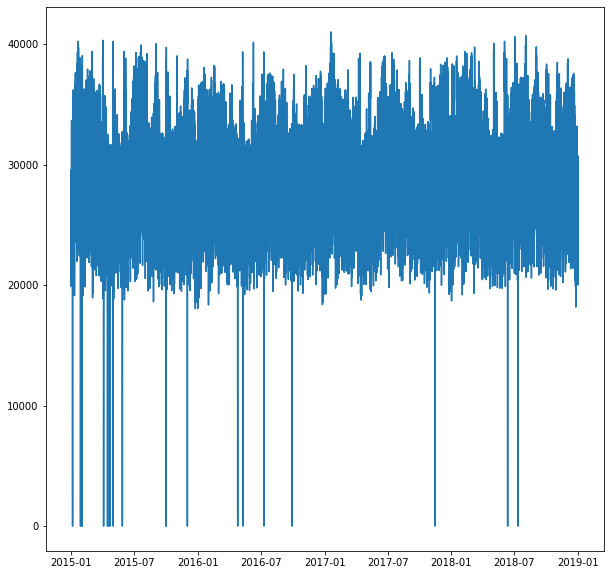

In [9]:
plt.figure(figsize=(10,10))
plt.plot(label.index, label)

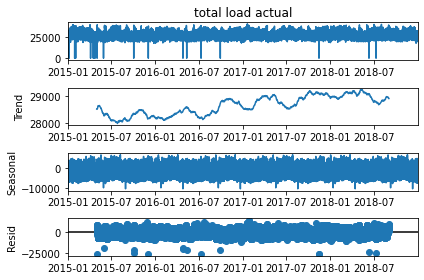

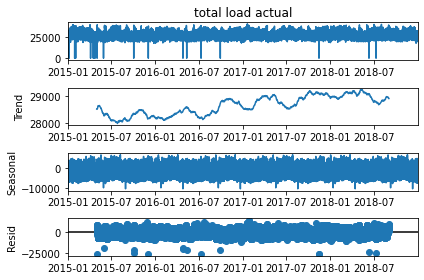

In [10]:
#SEASONALITY
nresult = seasonal_decompose(label, model='additive',period=5760)
nresult.plot()

In [8]:
def plot_ts(all_df_scaled, plt_value, name):
  """ 
  plots 1, month, 3 months, 1 year and 4 years of indicated label
  """
  plt.figure(figsize= (12,12))
  plt.subplot(2,2,1)
  plt.title(f"1 Month of {name} and Total Generation")
  plt.plot(all_df_scaled.index[:720], plt_value[:720])
  plt.plot(all_df_scaled.index[:720], all_df_scaled.label[:720])
  plt.legend([name,"Total generation"])
  plt.subplot(2,2,2)
  plt.title(f"3 Months of {name} and Total Generation")
  plt.plot(all_df_scaled.index[:2160], plt_value[:2160])
  plt.plot(all_df_scaled.index[:2160], all_df_scaled.label[:2160])
  plt.legend([name,"Total generation"])
  plt.subplot(2,2,3)
  plt.title(f"1 Year of {name} and Total Generation")
  plt.plot(all_df_scaled.index[:8640],plt_value[:8640])
  plt.plot(all_df_scaled.index[:8640], all_df_scaled.label[:8640])
  plt.legend([name,"Total generation"])
  plt.subplot(2,2,4)
  plt.title(f"4 Years of {name} and Total Generation")
  plt.plot(all_df_scaled.index, plt_value)
  plt.plot(all_df_scaled.index, all_df_scaled.label)
  plt.legend([name,"Total generation"])
  return 

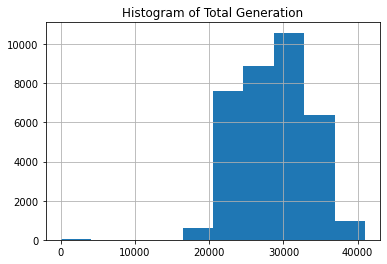

In [12]:
label.hist()
plt.title("Histogram of Total Generation")
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


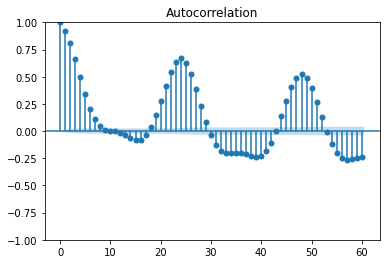

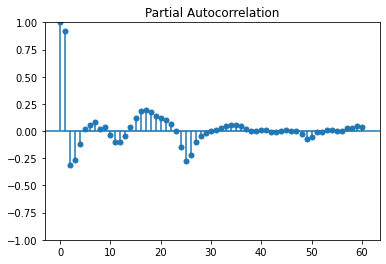

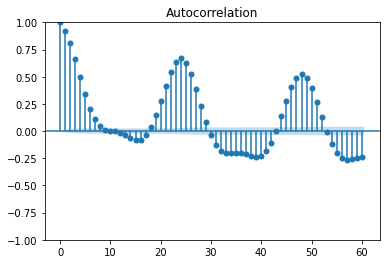

In [13]:
plot_pacf(label, lags = 60)
plot_acf(label, lags = 60)

In [14]:
result = adfuller(label)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -23.309405
p-value: 0.000000


The data is stationary

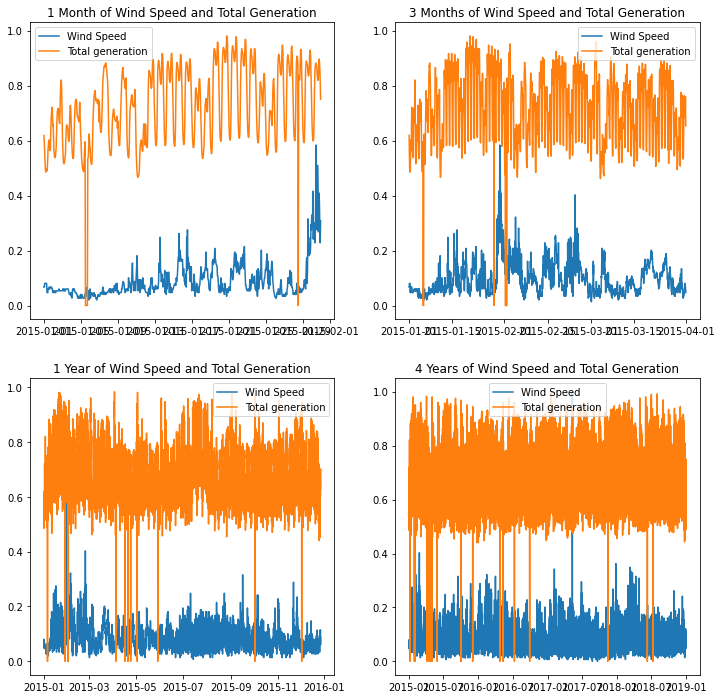

In [41]:
plot_ts(all_df_scaled, all_df_scaled.wind_speed, "Wind Speed")


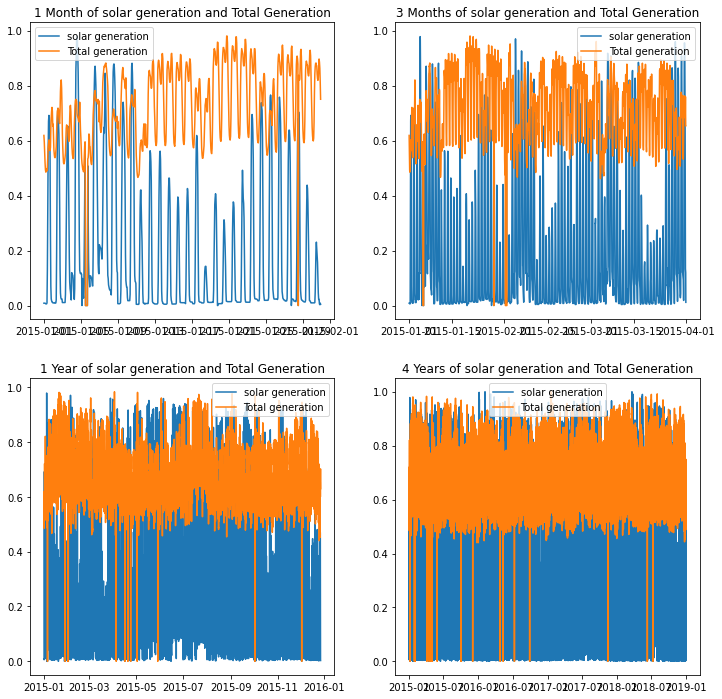

In [43]:
plot_ts(all_df_scaled, all_df_scaled["solar generation"], "solar generation")


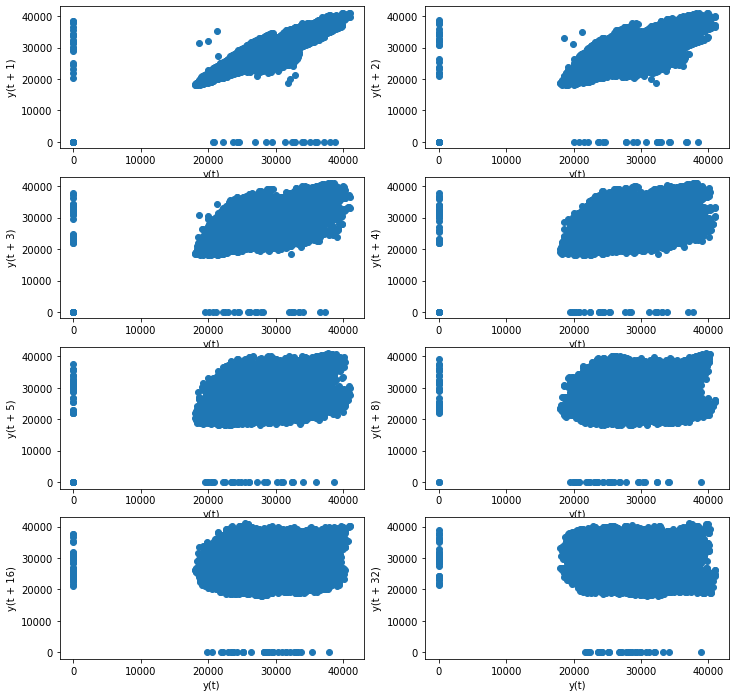

In [39]:
plt.figure(figsize=(12,12))
plt.subplot(4,2,1)
pd.plotting.lag_plot(label, lag=1)
plt.subplot(4,2,2)
pd.plotting.lag_plot(label, lag=2)
plt.subplot(4,2,3)
pd.plotting.lag_plot(label, lag=3)
plt.subplot(4,2,4)
pd.plotting.lag_plot(label, lag=4)
plt.subplot(4,2,5)
pd.plotting.lag_plot(label, lag=5)
plt.subplot(4,2,6)
pd.plotting.lag_plot(label, lag=8)
plt.subplot(4,2,7)
pd.plotting.lag_plot(label, lag=16)
plt.subplot(4,2,8)
pd.plotting.lag_plot(label, lag=32)
plt.show()

Lagged values of 1,2,3,4,5 are most related ones.

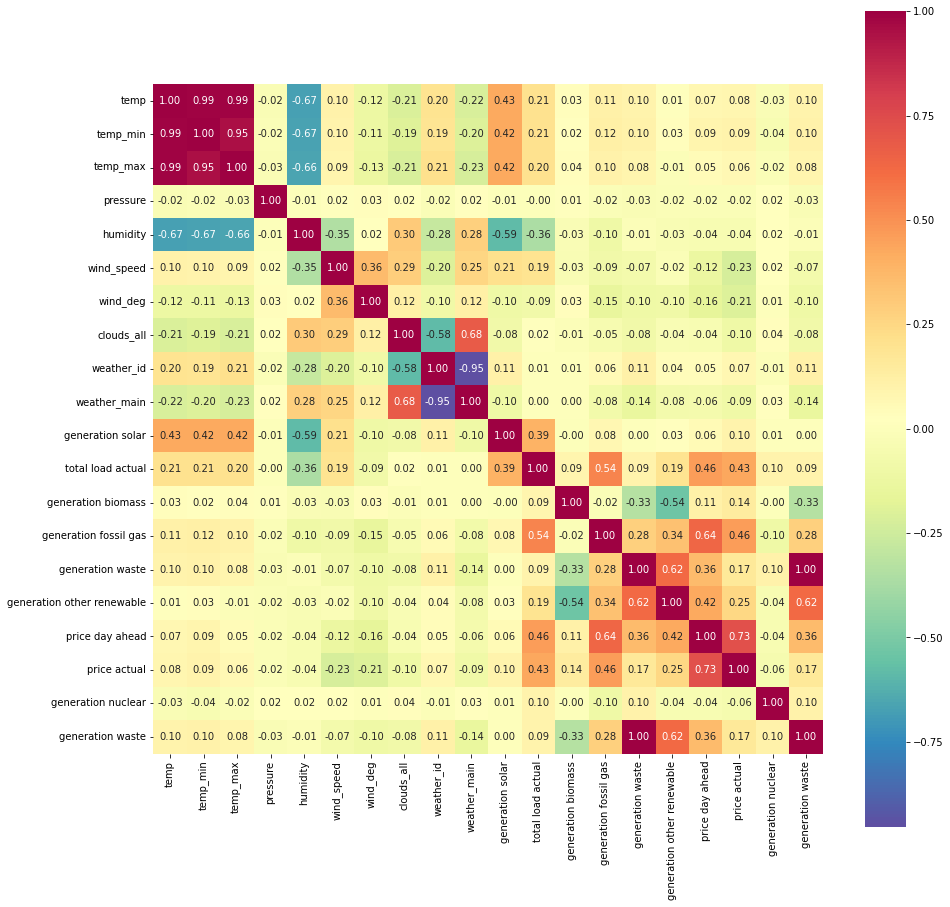

In [40]:
plt.figure(figsize=(15,15))
corrmat = all_df_scaled.corr()
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={"size":10},cmap ="Spectral_r")
plt.show()

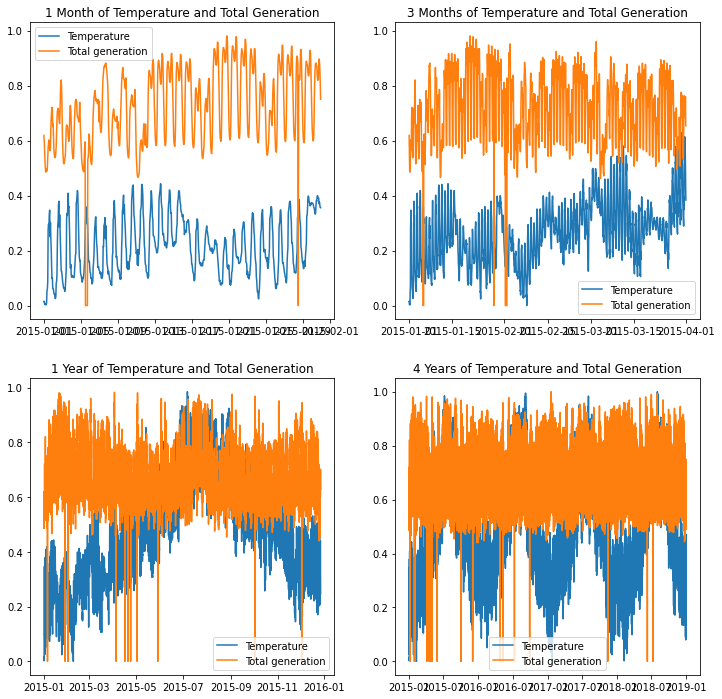

In [44]:
plot_ts(all_df_scaled, all_df_scaled.temp, "Temperature")

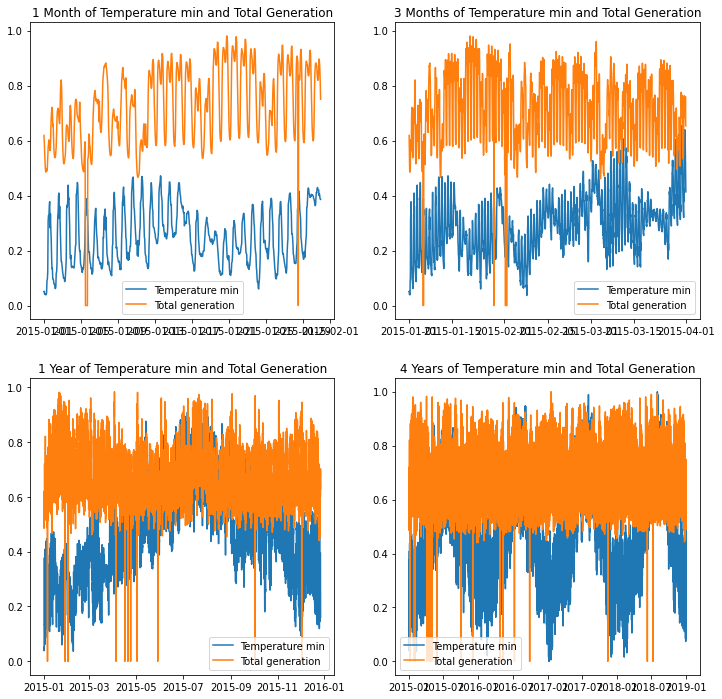

In [45]:
plot_ts(all_df_scaled, all_df_scaled.temp_min, "Temperature min")

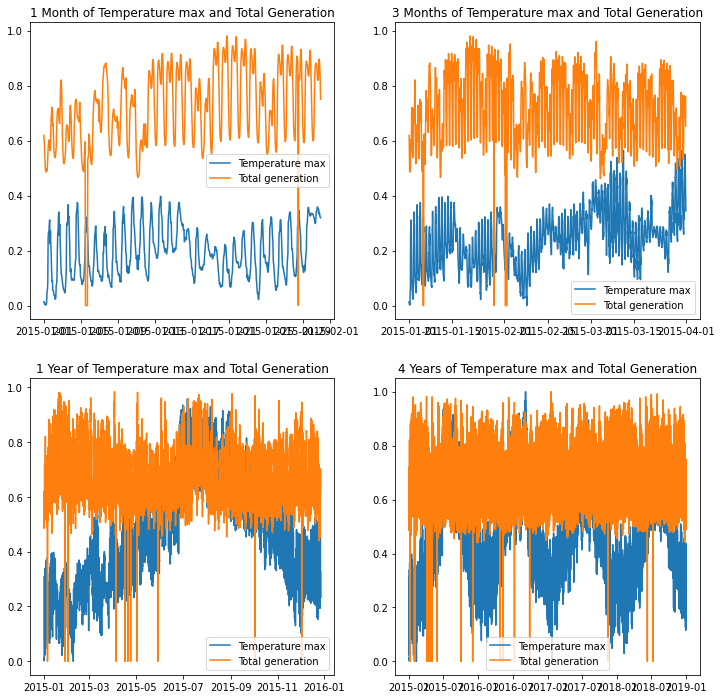

In [46]:
plot_ts(all_df_scaled, all_df_scaled.temp_max, "Temperature max")

The most correlated features are temp, temp_min, temp_max, humidity, generation solar

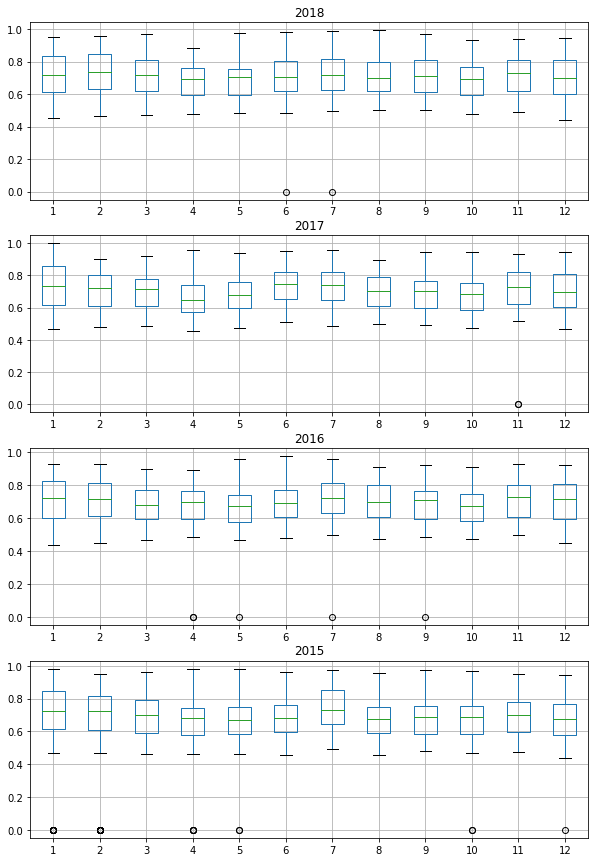

In [47]:

year = pd.DataFrame(all_df_scaled.index.year)
year = year.set_index(all_df_scaled.index)
year.columns = ["year"]
new_df = pd.concat([year, all_df_scaled],axis=1)
df_2018 = new_df[new_df.year==2018]
df_2017 = new_df[new_df.year==2017]
df_2016 = new_df[new_df.year==2016]
df_2015 = new_df[new_df.year==2015]

plt.figure(figsize=(10, 15))
plt.subplot(4,1,1)
groups = df_2018.label.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.title("2018")
plt.subplot(4,1,2)
groups = df_2017.label.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.title("2017")

plt.subplot(4,1,3)
groups = df_2016.label.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.title("2016")

plt.subplot(4,1,4)
groups = df_2015.label.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.title("2015")

plt.show()

In [30]:
final_df.columns

Index(['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'clouds_all', 'weather_id', 'weather_main',
       'generation solar', 'total load actual', 'generation biomass',
       'generation fossil gas', 'generation waste',
       'generation other renewable', 'price day ahead', 'price actual',
       'generation nuclear', 'generation waste', 'sin_hour', 'cos_hour',
       'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month', 'sin_year',
       'cos_year', 'sin_dayofyear', 'cos_dayofyear', 'sin_dayofmonth',
       'cos_dayofmonth', 'sin_weekofyear', 'cos_weekofyear',
       'season_of_the_year_sin', 'season_of_the_year_cos', 'shift3_roll2_mean',
       'shift4_roll3_mean', 'shift1', 'shift3_roll2_std', 'shift4_roll3_std',
       'shift2_expand', 'shift3_expand', 'shift4_expand', 'log_y',
       'log_y_t_1'],
      dtype='object')

FEATURES = ['generation_biomass',
 'generation_fossil_brown_coal/lignite',
 'generation_fossil_gas',
 'generation_fossil_hard_coal',
 'generation_fossil_oil',
 'generation_hydro_pumped_storage_consumption',
 'generation_hydro_run-of-river_and_poundage',
 'generation_hydro_water_reservoir',
 'generation_nuclear',
 'generation_other',
 'generation_other_renewable',
 'generation_solar',
 'generation_waste',
 'generation_wind_onshore',
 'forecast_solar_day_ahead',
 'forecast_wind_onshore_day_ahead',
 'total_load_forecast',
 'price_day_ahead',
 'price_actual',
 'hour',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'lag1',
 'lag2',
 'lag3']

#Feature Engineering

In [67]:
def feature_engineering(all_df, pred_wind = None):
  def sc_transform(c):
        max_val = c.max()
        sin_values = [math.sin((2 * math.pi * x) / max_val) for x in list(c)]
        cos_values = [math.cos((2 * math.pi * x) / max_val) for x in list(c)]
        return sin_values, cos_values
  # TIME FEATURES
  all_df['sin_hour'], all_df['cos_hour'] = sc_transform(all_df.index.hour)
  all_df['sin_dayofweek'],all_df['cos_dayofweek'] = sc_transform(all_df.index.dayofweek)
  all_df['sin_month'],all_df['cos_month'] = sc_transform(all_df.index.month)
  all_df['sin_year'],all_df['cos_year']= sc_transform(all_df.index.year)
  all_df['sin_dayofyear'], all_df['cos_dayofyear'] = sc_transform(all_df.index.dayofyear)
  all_df['sin_dayofmonth'],all_df['cos_dayofmonth'] = sc_transform(all_df.index.day)
  all_df['sin_weekofyear'],all_df['cos_weekofyear']= sc_transform(all_df.index.isocalendar().week)
  all_df["season_of_the_year_sin"], all_df["season_of_the_year_cos"] = sc_transform(pd.DatetimeIndex(all_df.index).month % 12 // 3)
  #LAG FEATURES
  if pred_wind:

    label = all_df["generation wind onshore"]
    label_copy = label.copy()
  else: 
    label = all_df["total load actual"]
    label_copy = label.copy()

  all_df["shift3_roll2_mean"] = label_copy.shift(1).rolling(2).mean()
  all_df["shift4_roll3_mean"] = label_copy.shift(2).rolling(3).mean()
  all_df["shift1"] = label_copy.shift(1)
  all_df["shift3_roll2_std"] = label_copy.shift(1).rolling(2).std()
  all_df["shift4_roll3_std"] = label_copy.shift(2).rolling(3).std()
  all_df["shift2_expand"] = label_copy.shift(2).expanding().mean()
  all_df["shift3_expand"] = label_copy.shift(3).expanding().mean()
  all_df["shift4_expand"] = label_copy.shift(4).expanding().mean()
  all_df["log_y"] = np.log(label_copy)
  all_df["log_y_t_1"] = np.log(label_copy.shift(1))
  all_df = all_df[(all_df.pressure> 4000) &(all_df.pressure<6000)]
  all_df = all_df[~all_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype(np.float64)

  all_df = all_df.dropna()

  return all_df

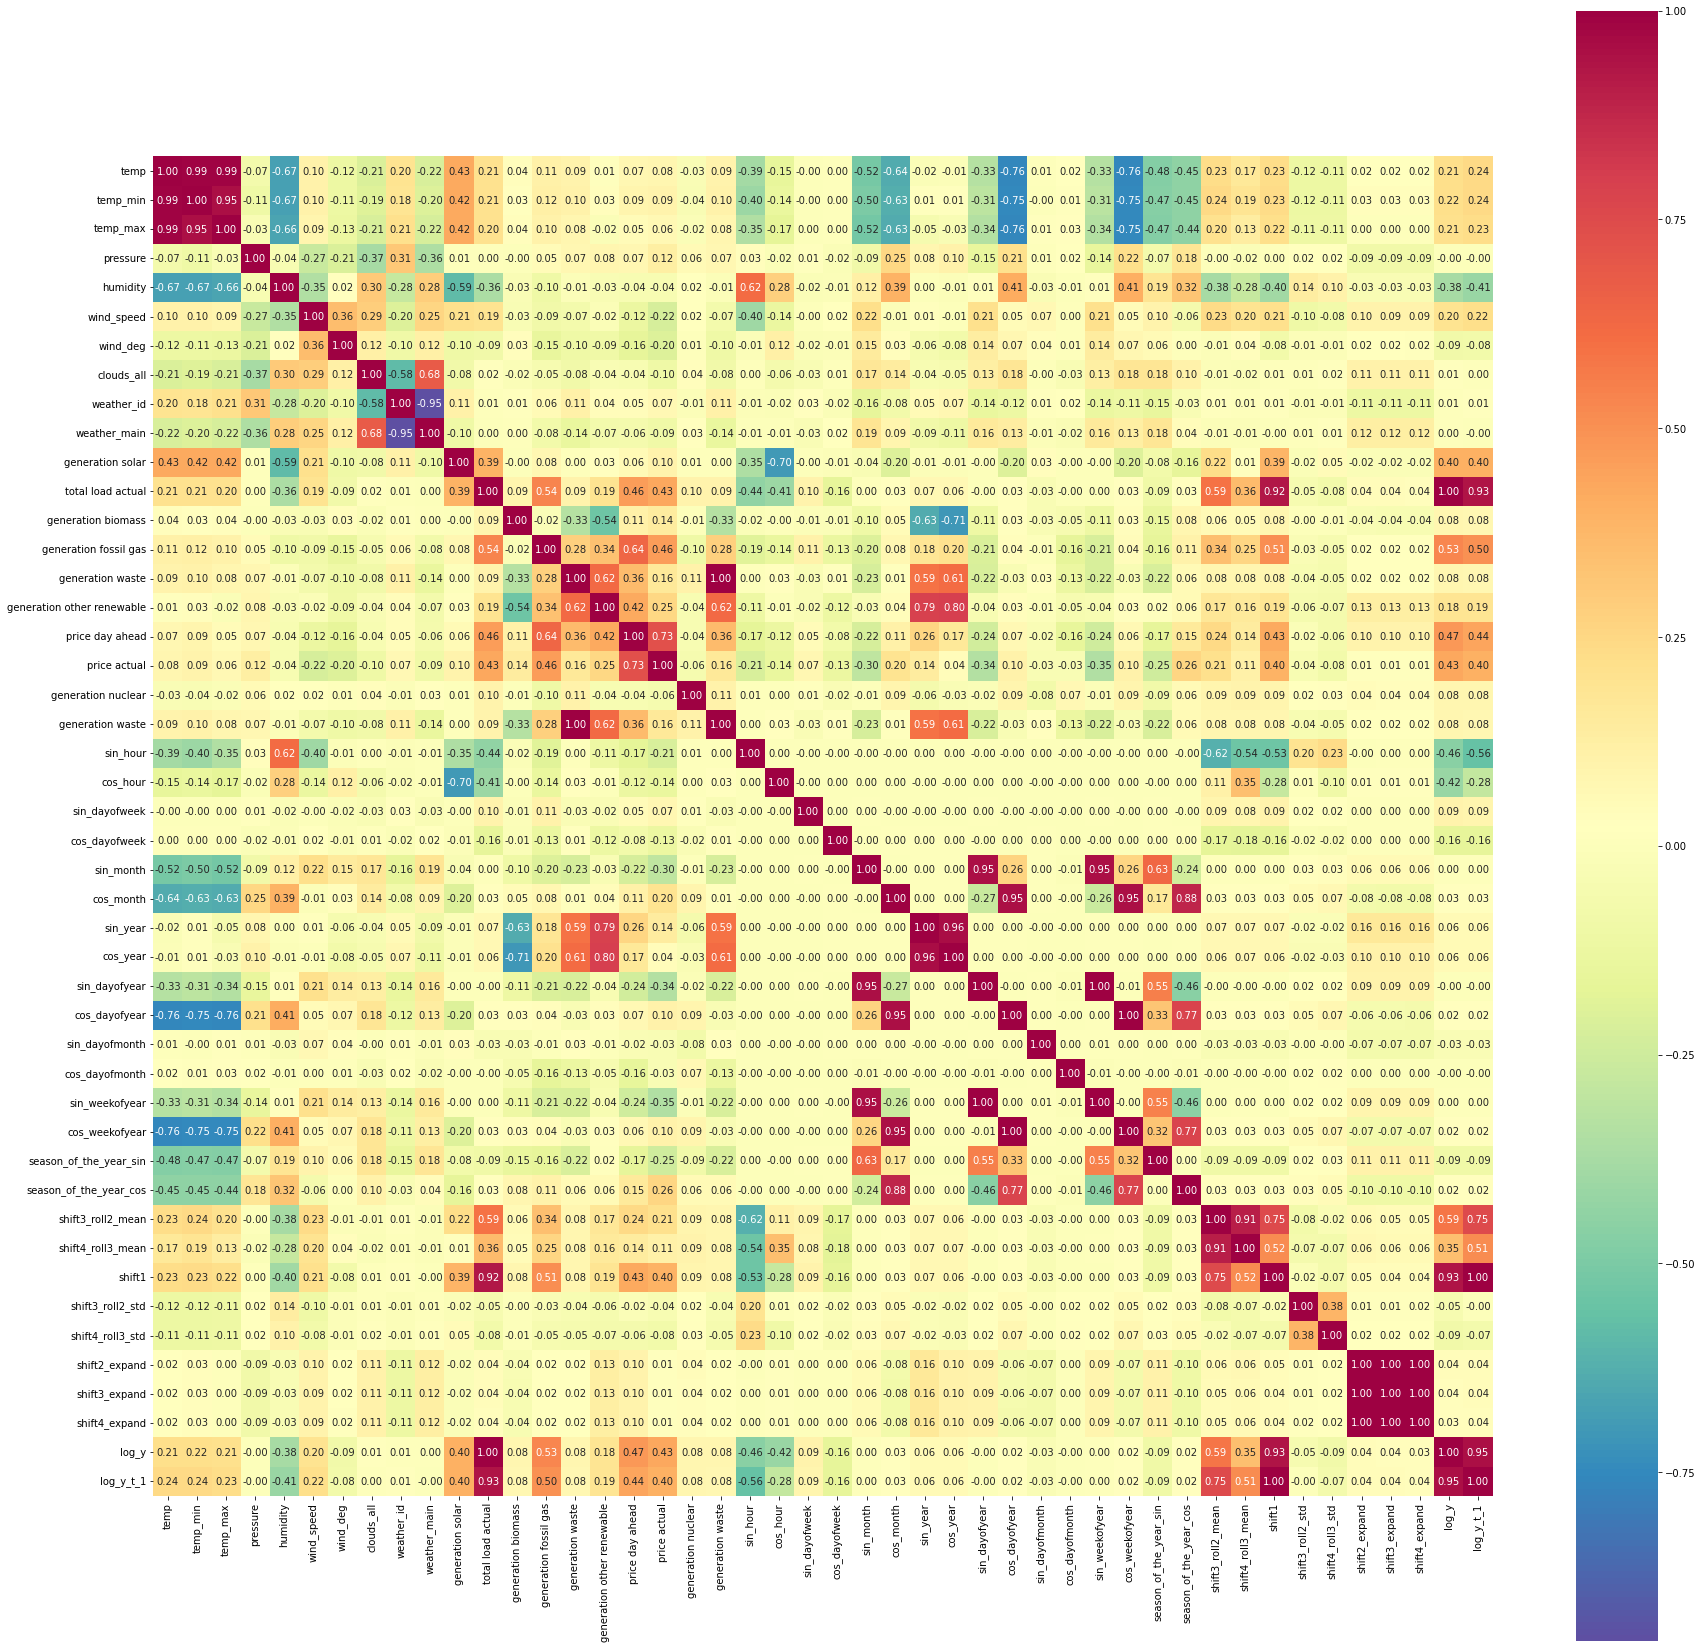

In [28]:
plt.figure(figsize=(30,30))
corrmat = last_df.corr()
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={"size":10},cmap ="Spectral_r")
plt.show()

WIND PREDİCTİON

In [68]:
last_df = feature_engineering(final_df,pred_wind = True)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [69]:
cols = [col for col in last_df if col != last_df.columns[15]] +[last_df.columns[15]]
last_df_new = last_df[cols]


In [70]:
last_df_new.columns

Index(['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'clouds_all', 'weather_id', 'weather_main',
       'generation solar', 'total load actual', 'generation biomass',
       'generation fossil gas', 'generation waste', 'generation waste',
       'generation other renewable', 'price day ahead', 'price actual',
       'generation nuclear', 'generation waste', 'generation waste',
       'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month',
       'cos_month', 'sin_year', 'cos_year', 'sin_dayofyear', 'cos_dayofyear',
       'sin_dayofmonth', 'cos_dayofmonth', 'sin_weekofyear', 'cos_weekofyear',
       'season_of_the_year_sin', 'season_of_the_year_cos', 'shift3_roll2_mean',
       'shift4_roll3_mean', 'shift1', 'shift3_roll2_std', 'shift4_roll3_std',
       'shift2_expand', 'shift3_expand', 'shift4_expand', 'log_y', 'log_y_t_1',
       'generation wind onshore'],
      dtype='object')

In [71]:
trainn = last_df_new.loc[:"2017-12-31 23:00:00"]
test = last_df_new.loc["2018-01-01 00:00:00":]

scaler = MinMaxScaler()
scaler = scaler.fit(trainn)
train = scaler.transform(trainn)
test = scaler.transform(test)
Y_train = pd.DataFrame(train[:,-1:])
Y_test = pd.DataFrame(test[:,-1:])
X_train = pd.DataFrame(train[:,:-1])
X_test = pd.DataFrame(test[:,:-1])

0.9999614670772564

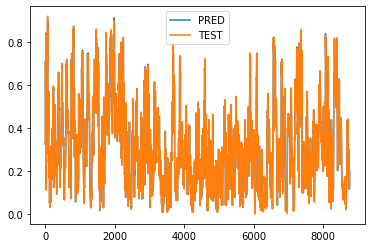

In [72]:
reg = lgb.LGBMRegressor().fit(X_train, Y_train)
y_pred = reg.predict(X_test)
plt.plot(Y_test.index, y_pred)
plt.plot(Y_test.index, Y_test)
plt.legend(["PRED","TEST"])
reg.score(X_train,Y_train)

#reg.score(X_test, Y_test)


#mean_squared_error(Y_test,y_pred)


In [73]:
reg.score(X_test, Y_test)

0.9999042000241511

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0002177918782562451

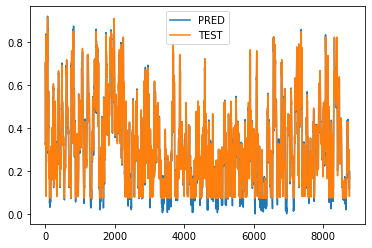

In [74]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor()
model.fit(X_train, Y_train)
y_pred  = model.predict(X_test)
plt.plot(Y_test.index, Y_test)

plt.plot(Y_test.index, 
         y_pred)
plt.legend(["PRED","TEST"])
mean_squared_error(Y_test,y_pred)

In [75]:
model.score(X_test, Y_test)

0.9941084693862621

0.00040799889723246955

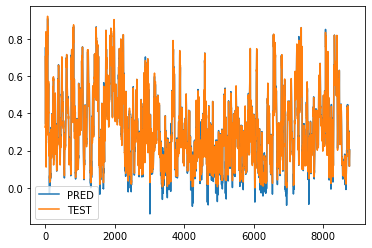

In [76]:
model = LinearRegression()
model.fit(X_train, Y_train)
y_pred  = model.predict(X_test)
y_pred_tra  = model.predict(X_train)

plt.plot(Y_test.index, 
         y_pred)
plt.plot(Y_test.index, Y_test)
plt.legend(["PRED","TEST"])
mean_squared_error(Y_test,y_pred)

In [77]:
model.score(X_test, Y_test)

0.9889631421857326

In [ ]:
###############################################################3

TOTAL LOAD PREDICTION

In [78]:
last_df = feature_engineering(final_df,pred_wind = False)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [79]:
cols = [col for col in last_df if col != last_df.columns[11]] +[last_df.columns[11]]
last_df_new = last_df[cols]

In [80]:
last_df_new.to_csv("Features_label_raw.csv")
!cp Features_label_raw.csv "/content/drive/MyDrive/EEE 485 Project/Code/"

In [81]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb


In [82]:
last_df_new.columns

Index(['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'clouds_all', 'weather_id', 'weather_main',
       'generation solar', 'generation biomass', 'generation fossil gas',
       'generation waste', 'generation waste', 'generation wind onshore',
       'generation other renewable', 'price day ahead', 'price actual',
       'generation nuclear', 'generation waste', 'generation waste',
       'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month',
       'cos_month', 'sin_year', 'cos_year', 'sin_dayofyear', 'cos_dayofyear',
       'sin_dayofmonth', 'cos_dayofmonth', 'sin_weekofyear', 'cos_weekofyear',
       'season_of_the_year_sin', 'season_of_the_year_cos', 'shift3_roll2_mean',
       'shift4_roll3_mean', 'shift1', 'shift3_roll2_std', 'shift4_roll3_std',
       'shift2_expand', 'shift3_expand', 'shift4_expand', 'log_y', 'log_y_t_1',
       'total load actual'],
      dtype='object')

In [83]:
trainn = last_df_new.loc[:"2017-12-31 23:00:00"]
test = last_df_new.loc["2018-01-01 00:00:00":]

scaler = MinMaxScaler()
scaler = scaler.fit(trainn)
train = scaler.transform(trainn)
test = scaler.transform(test)
Y_train = pd.DataFrame(train[:,-1:])
Y_test = pd.DataFrame(test[:,-1:])
X_train = pd.DataFrame(train[:,:-1])
X_test = pd.DataFrame(test[:,:-1])

0.999966674778066

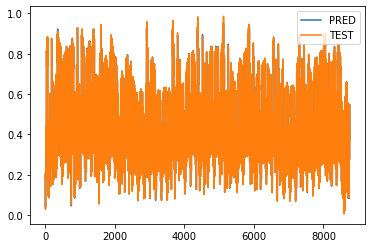

In [84]:
reg = lgb.LGBMRegressor().fit(X_train, Y_train)
y_pred = reg.predict(X_test)
plt.plot(Y_test.index, y_pred)
plt.plot(Y_test.index, Y_test)
plt.legend(["PRED","TEST"])
reg.score(X_train,Y_train)

#reg.score(X_test, Y_test)


#mean_squared_error(Y_test,y_pred)


In [85]:
reg.score(X_test, Y_test)

0.9999113415595179

4.886206893684728e-05

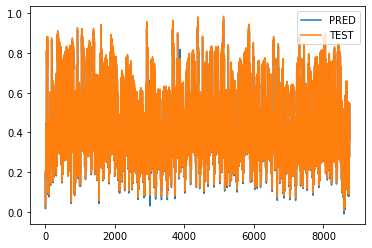

In [86]:
model = LinearRegression()
model.fit(X_train, Y_train)
y_pred  = model.predict(X_test)
y_pred_tra  = model.predict(X_train)

plt.plot(Y_test.index, 
         y_pred)
plt.plot(Y_test.index, Y_test)
plt.legend(["PRED","TEST"])
mean_squared_error(Y_test,y_pred)

In [87]:
r2_score(Y_test,y_pred),r2_score(Y_train,y_pred_tra)

(0.9987952753920187, 0.9988576650377109)

4.886206893684728e-05

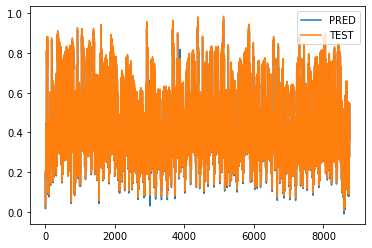

In [88]:
model = LinearRegression()
model.fit(X_train, Y_train)
y_pred  = model.predict(X_test)
y_pred_tra  = model.predict(X_train)

plt.plot(Y_test.index, 
         y_pred)
plt.plot(Y_test.index, Y_test)
plt.legend(["PRED","TEST"])
mean_squared_error(Y_test,y_pred)

In [89]:
r2_score(Y_test,y_pred),r2_score(Y_train,y_pred_tra)

(0.9987952753920187, 0.9988576650377109)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.00013270123392421413

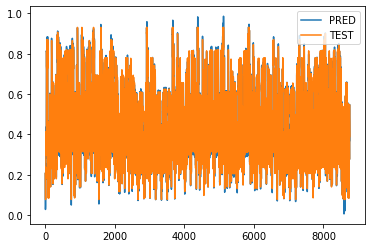

In [90]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor()
model.fit(X_train, Y_train)
y_pred  = model.predict(X_test)
plt.plot(Y_test.index, Y_test)

plt.plot(Y_test.index, 
         y_pred)
plt.legend(["PRED","TEST"])
mean_squared_error(Y_test,y_pred)

In [91]:
r2_score(Y_test,y_pred)

0.9967281687923489